In [40]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp

In [41]:
import sys
import os

# Add project root (two levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)

/home/mak/Documents


In [42]:
!ls && pwd 
%cd /home/mak/Documents/Optimization/Project


data  data_cleaning.ipynb  illinois_corn_fields_synthetic.csv  src
/home/mak/Documents/Optimization/Project
/home/mak/Documents/Optimization/Project


In [43]:
wm = pd.read_csv("data/processed/master_weekly_table.csv")
wm = wm[(wm["year"] >= 2017) & (wm["year"] <= 2024)].copy()
wm.to_csv("data/processed/master_weekly_table_2017_2024.csv", index=False)

In [44]:
!ls

data  data_cleaning.ipynb  illinois_corn_fields_synthetic.csv  src


# 1️⃣ Make labor realistic (seasonal, not 5M hours every week)
Right now, after you build weekly_master, every row has the same labor_hours ≈ 5,057,910.
We’ll keep that as the annual pool, but scale it by week.

In [45]:
import numpy as np

# Assume weekly_master is already built and contains `year`, `week`, `labor_hours`
# wm = weekly_master.copy()

# (Optional) keep original labor for reference
wm["labor_hours_base"] = wm["labor_hours"]

def labor_season_factor(week: int) -> float:
    """
    Fraction of the annual labor pool effectively available in a given week.
    Tune these numbers as you like.
    """
    # Peak field activity during planting
    if 16 <= week <= 20:
        return 0.30      # 30% of annual workforce active in field

    # Peak field activity during harvest
    elif 36 <= week <= 45:
        return 0.40      # 40% of annual workforce

    # Shoulder / off-season
    else:
        return 0.10      # 10% in field operations

# Apply seasonal factor
wm["labor_hours"] = wm.apply(
    lambda r: r["labor_hours_base"] * labor_season_factor(int(r["week"])),
    axis=1,
)

# Overwrite weekly_master and resave
weekly_master = wm
weekly_master.to_csv("data/processed/master_weekly_table.csv", index=False)

weekly_master.head(15)


,year,week,prcp_week_in,TMAX,TMIN,TAVG,AWND,capacity_factor,rain_category,labor_hours,plant_start_week,plant_end_week,harvest_start_week,harvest_end_week,is_plant_window,is_harvest_window,labor_hours_base
0,2017,1,0.250769,25.728571,9.250000,17.942857,9.320779,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
1,2017,2,0.432308,39.242857,21.814286,29.457143,10.768831,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
2,2017,3,1.402564,47.242857,35.128571,40.342857,8.135065,0.7,moderate,5057.91,15,21,36,45.0,False,False,50579.1
3,2017,4,0.080513,37.771429,29.285714,33.600000,11.251948,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
4,2017,5,0.012564,37.792857,19.971429,29.942857,10.162338,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
5,2017,6,0.416384,46.728571,24.442857,36.114286,11.287013,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
6,2017,7,0.004615,56.705036,30.200000,43.857143,8.167532,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
7,2017,8,0.272051,58.392857,36.657143,48.085714,10.910390,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1
8,2017,9,0.826667,52.726619,31.014286,42.742857,11.842857,0.7,moderate,5057.91,15,21,36,45.0,False,False,50579.1
9,2017,10,0.438205,50.485714,31.900000,41.457143,11.945455,0.9,light,5057.91,15,21,36,45.0,False,False,50579.1


In [46]:
"""
    🚀 4. Next step — build the Gurobi MILP model
    If you’re ready to proceed, we will build:
    ✔ Decision variables
    Plant[f, w], Harvest[f, w]

    ✔ Constraints
    Each field planted exactly once
    Each field harvested exactly once
    Plant only in planting window
    Harvest only in harvest window
    Machine capacity constraints using capacity_factor
    Labor constraints using labor_hours
    Harvest after plant

    ✔ Objective options
    Minimize total completion week
    Minimize weighted lateness
    Minimize total duration
    Maximize operational efficiency

    We’ll implement it cleanly in:

    src/optimization/milp_scheduler.py_summary_
"""

'\n    🚀 4. Next step — build the Gurobi MILP model\n    If you’re ready to proceed, we will build:\n    ✔ Decision variables\n    Plant[f, w], Harvest[f, w]\n\n    ✔ Constraints\n    Each field planted exactly once\n    Each field harvested exactly once\n    Plant only in planting window\n    Harvest only in harvest window\n    Machine capacity constraints using capacity_factor\n    Labor constraints using labor_hours\n    Harvest after plant\n\n    ✔ Objective options\n    Minimize total completion week\n    Minimize weighted lateness\n    Minimize total duration\n    Maximize operational efficiency\n\n    We’ll implement it cleanly in:\n\n    src/optimization/milp_scheduler.py_summary_\n'

In [47]:
!ls && pwd

data  data_cleaning.ipynb  illinois_corn_fields_synthetic.csv  src
/home/mak/Documents/Optimization/Project


In [48]:
from src.optimization.milp_scheduler import build_and_solve_schedule

schedule_2017 = build_and_solve_schedule(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    base_planter_capacity=1000.0,
    base_harvester_capacity=600.0,
    labor_plant_per_acre=0.30,
    labor_harvest_per_acre=0.40,
    min_harvest_lag_weeks=6,
    time_limit=60
)

schedule_2017

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 249 rows, 476 columns and 1850 nonzeros (Min)
Model fingerprint: 0x6196115e
Model has 1 linear objective coefficients
Variable types: 51 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 45.0000000
Presolve removed 189 rows and 225 columns
Presolve time: 0.00s
Presolved: 60 rows, 251 columns, 750 nonzeros
Variable types: 0 continuous, 251 integer (250 binary)

Root relaxation: objective 3.745115e+01, 119 iterations, 0.00 s

,field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan
0,F001,16,37,16.0,37.0,2,39.0
1,F002,16,39,16.0,39.0,2,39.0
2,F003,19,37,19.0,37.0,2,39.0
3,F004,16,36,16.0,36.0,2,39.0
4,F005,16,38,16.0,38.0,2,39.0
5,F006,17,39,17.0,39.0,2,39.0
6,F007,19,37,19.0,37.0,2,39.0
7,F008,20,39,20.0,39.0,2,39.0
8,F009,15,39,15.0,39.0,2,39.0
9,F010,19,39,19.0,39.0,2,39.0


In [49]:
schedule_2017.head(20)

,field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan
0,F001,16,37,16.0,37.0,2,39.0
1,F002,16,39,16.0,39.0,2,39.0
2,F003,19,37,19.0,37.0,2,39.0
3,F004,16,36,16.0,36.0,2,39.0
4,F005,16,38,16.0,38.0,2,39.0
5,F006,17,39,17.0,39.0,2,39.0
6,F007,19,37,19.0,37.0,2,39.0
7,F008,20,39,20.0,39.0,2,39.0
8,F009,15,39,15.0,39.0,2,39.0
9,F010,19,39,19.0,39.0,2,39.0


3️⃣ (Optional but nice) Make harvest capacity more weather-sensitive

If you want harvest to match NASS even better, refine compute_harvest_weather_factor.

🔧 Where

In src/optimization/weather_capacity.py
Find your existing compute_harvest_weather_factor and replace it with:

In [50]:
def compute_harvest_weather_factor(row) -> float:
    """
    Extra harvest penalty for bad drying conditions.

    Uses:
      - prcp_week_in : weekly rainfall (inches)
      - TAVG         : avg temp (F)
    """
    prcp = row.get("prcp_week_in", 0.0) or 0.0
    tavg = row.get("TAVG", 60.0) or 60.0

    # Start from 1.0 (no penalty)
    factor = 1.0

    # Heavy rain → strong penalty
    if prcp > 1.5:
        factor *= 0.4
    elif prcp > 0.8:
        factor *= 0.7
    else:
        factor *= 1.0

    # Cool temps → slower drying
    if tavg < 40:
        factor *= 0.6
    elif tavg < 50:
        factor *= 0.8

    # Clamp to [0.2, 1.0]
    return float(np.clip(factor, 0.2, 1.0))

In [51]:
import pandas as pd

fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
sched = schedule_2017.merge(fields, on="field_id", how="left")
sched.head()

,field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan,acres,centroid_lat,centroid_lon,region
0,F001,16,37,16.0,37.0,2,39.0,87.227749,39.389277,-89.900275,South
1,F002,16,39,16.0,39.0,2,39.0,54.752514,39.933442,-90.477913,Central
2,F003,19,37,19.0,37.0,2,39.0,101.833288,39.087608,-88.139227,South
3,F004,16,36,16.0,36.0,2,39.0,108.790255,39.308579,-88.505447,South
4,F005,16,38,16.0,38.0,2,39.0,40.000000,40.366098,-88.384504,North


In [52]:
sched.head(3)

,field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan,acres,centroid_lat,centroid_lon,region
0,F001,16,37,16.0,37.0,2,39.0,87.227749,39.389277,-89.900275,South
1,F002,16,39,16.0,39.0,2,39.0,54.752514,39.933442,-90.477913,Central
2,F003,19,37,19.0,37.0,2,39.0,101.833288,39.087608,-88.139227,South


In [53]:
wm = pd.read_csv("data/processed/master_weekly_table.csv")
wm_2017 = wm[wm["year"] == 2017].copy()
# Planting acres per week
plant_by_week = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .rename("plant_acres")
    .reset_index()
)
# Harvest acres per week
harvest_by_week = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .rename("harvest_acres")
    .reset_index()
)
# Merge with master to compare against capacity
weekly_view = (
    wm_2017[["week", "capacity_factor", "labor_hours"]]
    .merge(plant_by_week, left_on="week", right_on="plant_week", how="left")
    .merge(harvest_by_week, left_on="week", right_on="harvest_week", how="left")
)

weekly_view["plant_week"] = weekly_view["plant_week"].fillna(0).astype(int)
weekly_view["harvest_week"] = weekly_view["harvest_week"].fillna(0).astype(int)

weekly_view["plant_acres"] = weekly_view["plant_acres"].fillna(0)
weekly_view["harvest_acres"] = weekly_view["harvest_acres"].fillna(0)
weekly_view.head(15)

,week,capacity_factor,labor_hours,plant_week,plant_acres,harvest_week,harvest_acres
0,1,0.9,5057.91,0,0.000000,0,0.0
1,2,0.9,5057.91,0,0.000000,0,0.0
2,3,0.7,5057.91,0,0.000000,0,0.0
3,4,0.9,5057.91,0,0.000000,0,0.0
4,5,0.9,5057.91,0,0.000000,0,0.0
5,6,0.9,5057.91,0,0.000000,0,0.0
6,7,0.9,5057.91,0,0.000000,0,0.0
7,8,0.9,5057.91,0,0.000000,0,0.0
8,9,0.7,5057.91,0,0.000000,0,0.0
9,10,0.9,5057.91,0,0.000000,0,0.0


In [54]:
base_planter_capacity = 1400.0
base_harvester_capacity = 950.0

weekly_view["plant_capacity"] = (
    base_planter_capacity * weekly_view["capacity_factor"]
)
weekly_view["harvest_capacity"] = (
    base_harvester_capacity * weekly_view["capacity_factor"]
)

weekly_view["plant_utilization"] = (
    weekly_view["plant_acres"] / weekly_view["plant_capacity"]
)
weekly_view["harvest_utilization"] = (
    weekly_view["harvest_acres"] / weekly_view["harvest_capacity"]
)

weekly_view[["week", "plant_acres", "plant_capacity", "plant_utilization",
             "harvest_acres", "harvest_capacity", "harvest_utilization"]]


,week,plant_acres,plant_capacity,plant_utilization,harvest_acres,harvest_capacity,harvest_utilization
0,1,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
1,2,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
2,3,0.000000,980.0,0.000000,0.000000,665.0,0.000000
3,4,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
4,5,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
5,6,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
6,7,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
7,8,0.000000,1260.0,0.000000,0.000000,855.0,0.000000
8,9,0.000000,980.0,0.000000,0.000000,665.0,0.000000
9,10,0.000000,1260.0,0.000000,0.000000,855.0,0.000000


In [55]:
schedule_2017.to_csv("data/processed/schedule_2017.csv", index=False)
schedule_2017.to_csv()

',field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,status,objective_makespan\n0,F001,16,37,16.0,37.0,2,39.0\n1,F002,16,39,16.0,39.0,2,39.0\n2,F003,19,37,19.0,37.0,2,39.0\n3,F004,16,36,16.0,36.0,2,39.0\n4,F005,16,38,16.0,38.0,2,39.0\n5,F006,17,39,17.0,39.0,2,39.0\n6,F007,19,37,19.0,37.0,2,39.0\n7,F008,20,39,20.0,39.0,2,39.0\n8,F009,15,39,15.0,39.0,2,39.0\n9,F010,19,39,19.0,39.0,2,39.0\n10,F011,19,39,19.0,39.0,2,39.0\n11,F012,15,38,15.0,38.0,2,39.0\n12,F013,15,36,15.0,36.0,2,39.0\n13,F014,17,36,17.0,36.0,2,39.0\n14,F015,21,37,21.0,37.0,2,39.0\n15,F016,19,38,19.0,38.0,2,39.0\n16,F017,21,37,21.0,37.0,2,39.0\n17,F018,18,39,18.0,39.0,2,39.0\n18,F019,15,36,15.0,36.0,2,39.0\n19,F020,19,38,19.0,38.0,2,39.0\n20,F021,16,38,16.0,38.0,2,39.0\n21,F022,15,39,15.0,39.0,2,39.0\n22,F023,19,36,19.0,36.0,2,39.0\n23,F024,21,37,21.0,37.0,2,39.0\n24,F025,20,38,20.0,38.0,2,39.0\n'

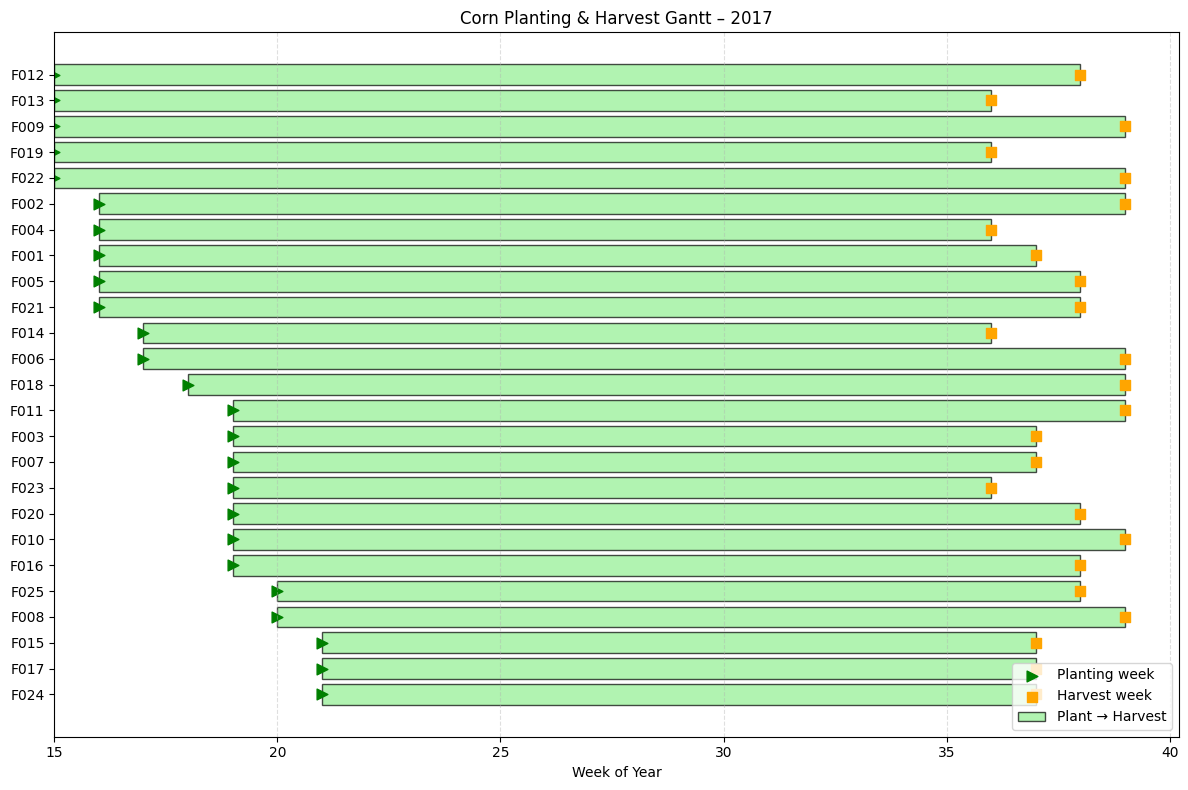

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load schedule
# If you saved it elsewhere, change the path accordingly
schedule_2017 = pd.read_csv("data/processed/schedule_2017.csv")

# 2. Sort by planting week so the chart looks orderly
schedule_2017 = schedule_2017.sort_values("plant_week").reset_index(drop=True)

# (Optional) Limit number of fields shown, so the plot stays readable
max_fields = 30   # change or remove this to plot all fields
plot_df = schedule_2017.head(max_fields).copy()

# Duration of each field's growing season
plot_df["duration"] = plot_df["harvest_week"] - plot_df["plant_week"]

# 3. Build colored Gantt chart
fig, ax = plt.subplots(figsize=(12, 8))

y_positions = list(range(len(plot_df)))

# Growing season bar (plant → harvest)
ax.barh(
    y_positions,
    plot_df["duration"],
    left=plot_df["plant_week"],
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    label="Plant → Harvest"
)

# Mark planting week (green triangle)
ax.scatter(
    plot_df["plant_week"],
    y_positions,
    color="green",
    marker=">",
    s=60,
    label="Planting week"
)

# Mark harvest week (orange square)
ax.scatter(
    plot_df["harvest_week"],
    y_positions,
    color="orange",
    marker="s",
    s=60,
    label="Harvest week"
)

# 4. Labeling & styling
ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df["field_id"])
ax.set_xlabel("Week of Year")
ax.set_title("Corn Planting & Harvest Gantt – 2017")
ax.invert_yaxis()  # first field at top
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


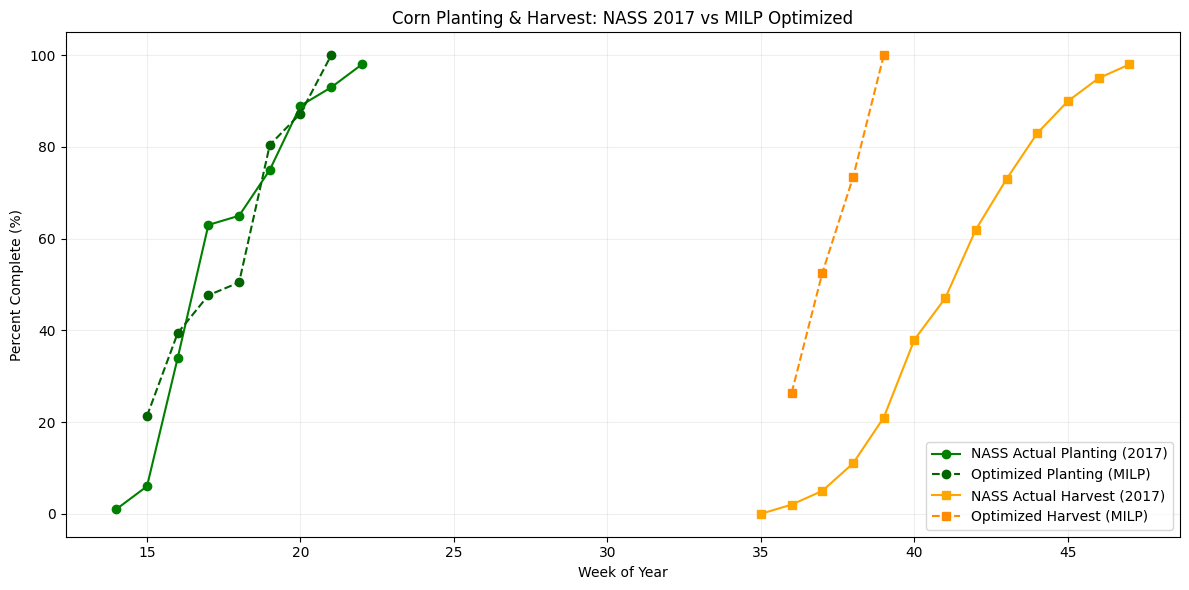

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------
# Load datasets
# ------------------------

# NASS planting (cleaned)
plant_nass_path = "data/processed/nass_corn_planting_weekly_clean.csv"
plant_nass = pd.read_csv(plant_nass_path)

# NASS harvest (cleaned)
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"
harvest_nass = pd.read_csv(harvest_nass_path)

# MILP optimized schedule for 2017
sched = pd.read_csv("data/processed/schedule_2017.csv")

# ------------------------
# Filter NASS for 2017
# ------------------------
plant_nass_2017 = plant_nass[plant_nass["Year"] == 2017].copy()
harvest_nass_2017 = harvest_nass[harvest_nass["Year"] == 2017].copy()

# Rename for easier use
plant_nass_2017 = plant_nass_2017[["week", "pct_planted"]].sort_values("week")
harvest_nass_2017 = harvest_nass_2017[["week", "pct_harvested"]].sort_values("week")

# ------------------------
# Build Optimized Curves
# ------------------------

# Insert field acres
fields = pd.read_csv("data/processed/illinois_corn_fields_clean.csv")
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

total_acres = sched["acres"].sum()

# MILP planting curve (%)
plant_curve_opt = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100
)

# MILP harvest curve (%)
harvest_curve_opt = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100
)

# ------------------------
# Plot Comparison
# ------------------------
plt.figure(figsize=(12, 6))

# Planting
plt.plot(plant_nass_2017["week"], plant_nass_2017["pct_planted"],
         label="NASS Actual Planting (2017)", marker="o", color="green")
plt.plot(plant_curve_opt.index, plant_curve_opt.values,
         label="Optimized Planting (MILP)", marker="o", linestyle="--", color="darkgreen")

# Harvest
plt.plot(harvest_nass_2017["week"], harvest_nass_2017["pct_harvested"],
         label="NASS Actual Harvest (2017)", marker="s", color="orange")
plt.plot(harvest_curve_opt.index, harvest_curve_opt.values,
         label="Optimized Harvest (MILP)", marker="s", linestyle="--", color="darkorange")

plt.xlabel("Week of Year")
plt.ylabel("Percent Complete (%)")
plt.title("Corn Planting & Harvest: NASS 2017 vs MILP Optimized")
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


# MILP V2


In [58]:
from src.optimization.milp_schedulerv2 import build_and_solve_schedule_v2

schedule_2017_v2 = build_and_solve_schedule_v2(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    base_planter_capacity=1000.0,
    base_harvester_capacity=750.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    min_harvest_lag_weeks=6,
    phys_maturity_lag_weeks=16,
    late_buffer_weeks=3,
    early_penalty_weight=10.0,
    late_penalty_weight=5.0,
    time_limit=60,
)

schedule_2017_v2.head()

Set parameter TimeLimit to value 60
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x3fb82374
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 775.0000000
Presolve removed 207 rows and 33 columns
Presolve time: 0.00s
Presolved: 142 rows, 493 columns, 1301 nonzeros
Variable types: 0 continuous, 493 integer (417 binary)

Root relaxation: objective 3.706394e+01, 412 iterations, 0.

,field_id,plant_week,harvest_week,plant_week_continuous,harvest_week_continuous,early_penalty,late_penalty,status,objective_makespan
0,F001,18,37,18.0,37.0,0.0,0.0,2,39.0
1,F002,18,37,18.0,37.0,0.0,0.0,2,39.0
2,F003,20,37,20.0,37.0,0.0,0.0,2,39.0
3,F004,20,39,20.0,39.0,0.0,0.0,2,39.0
4,F005,19,38,19.0,38.0,0.0,0.0,2,39.0


In [59]:
schedule_2017_v2.to_csv("data/processed/schedule_2017_v2.csv", index=False)


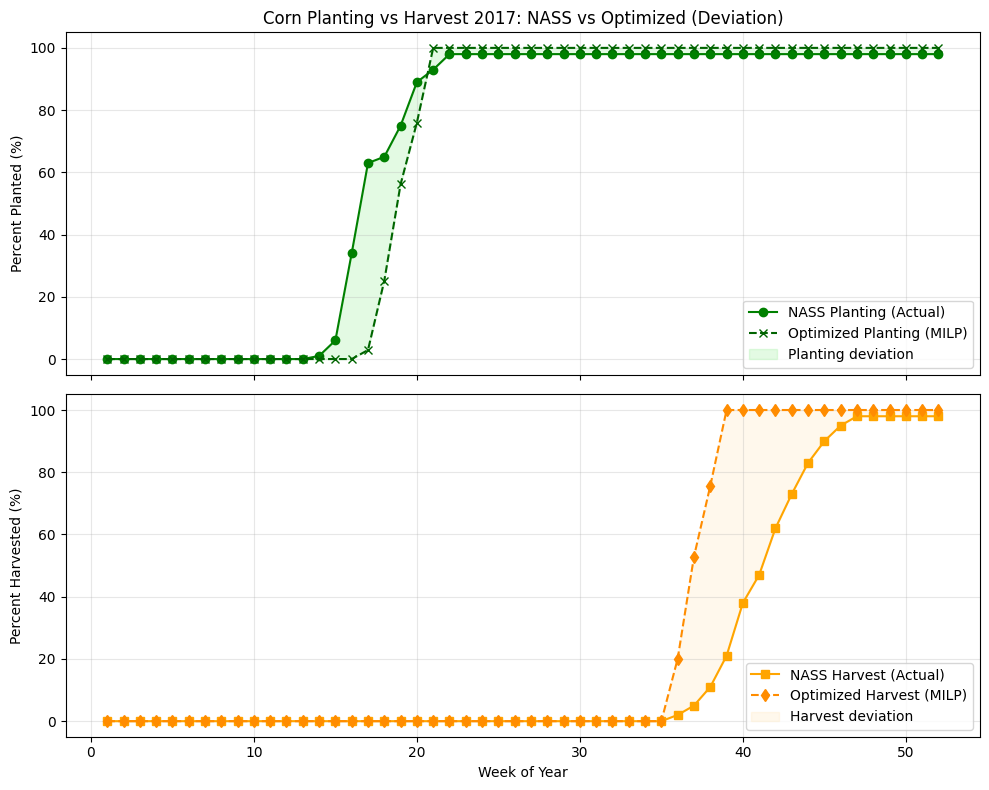

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

target_year = 2017

# ---------- PATHS ----------
schedule_path = "data/processed/schedule_2017_v2.csv"  # or schedule_2017.csv
fields_path   = "data/processed/illinois_corn_fields_clean.csv"

plant_nass_path   = "data/processed/nass_corn_planting_weekly_clean.csv"
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"

# ---------- 1. LOAD DATA ----------

# Schedule + fields (for acres)
sched = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)

sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")
total_acres = sched["acres"].sum()

# Clean NASS
plant_nass   = pd.read_csv(plant_nass_path)
harvest_nass = pd.read_csv(harvest_nass_path)

plant_nass_yr   = plant_nass[plant_nass["Year"] == target_year].copy()
harvest_nass_yr = harvest_nass[harvest_nass["Year"] == target_year].copy()

# ---------- 2. BUILD CURVES (ACTUAL vs OPTIMIZED) ----------

# Weeks universe (1–52)
weeks = pd.Index(range(1, 53), name="week")

# NASS planting curve (already %)
plant_actual = (
    plant_nass_yr.set_index("week")["pct_planted"]
    .reindex(weeks)
    .ffill()
    .fillna(0)
)

# NASS harvest curve
harvest_actual = (
    harvest_nass_yr.set_index("week")["pct_harvested"]
    .reindex(weeks)
    .ffill()
    .fillna(0)
)

# Optimized planting (% of total acres)
plant_opt = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100.0
)
plant_opt = plant_opt.reindex(weeks).ffill().fillna(0)

# Optimized harvest (% of total acres)
harvest_opt = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .cumsum() / total_acres * 100.0
)
harvest_opt = harvest_opt.reindex(weeks).ffill().fillna(0)

# Deviation (absolute)
plant_diff   = (plant_opt   - plant_actual).abs()
harvest_diff = (harvest_opt - harvest_actual).abs()

# ---------- 3. PLOT: 2-ROW DEVIATION vs ACTUAL ----------

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Row 1: Planting ---
ax = axes[0]

ax.plot(weeks, plant_actual, label="NASS Planting (Actual)", color="green", marker="o")
ax.plot(weeks, plant_opt,    label="Optimized Planting (MILP)", color="darkgreen",
        linestyle="--", marker="x")

# Shaded deviation area
ax.fill_between(
    weeks,
    plant_actual,
    plant_opt,
    where=None,
    alpha=0.25,
    color="lightgreen",
    label="Planting deviation"
)

ax.set_ylabel("Percent Planted (%)")
ax.set_title(f"Corn Planting vs Harvest {target_year}: NASS vs Optimized (Deviation)")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")

# --- Row 2: Harvest ---
ax = axes[1]

ax.plot(weeks, harvest_actual, label="NASS Harvest (Actual)", color="orange", marker="s")
ax.plot(weeks, harvest_opt,    label="Optimized Harvest (MILP)", color="darkorange",
        linestyle="--", marker="d")

ax.fill_between(
    weeks,
    harvest_actual,
    harvest_opt,
    where=None,
    alpha=0.25,
    color="moccasin",
    label="Harvest deviation"
)

ax.set_xlabel("Week of Year")
ax.set_ylabel("Percent Harvested (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Regional Breakdown Code

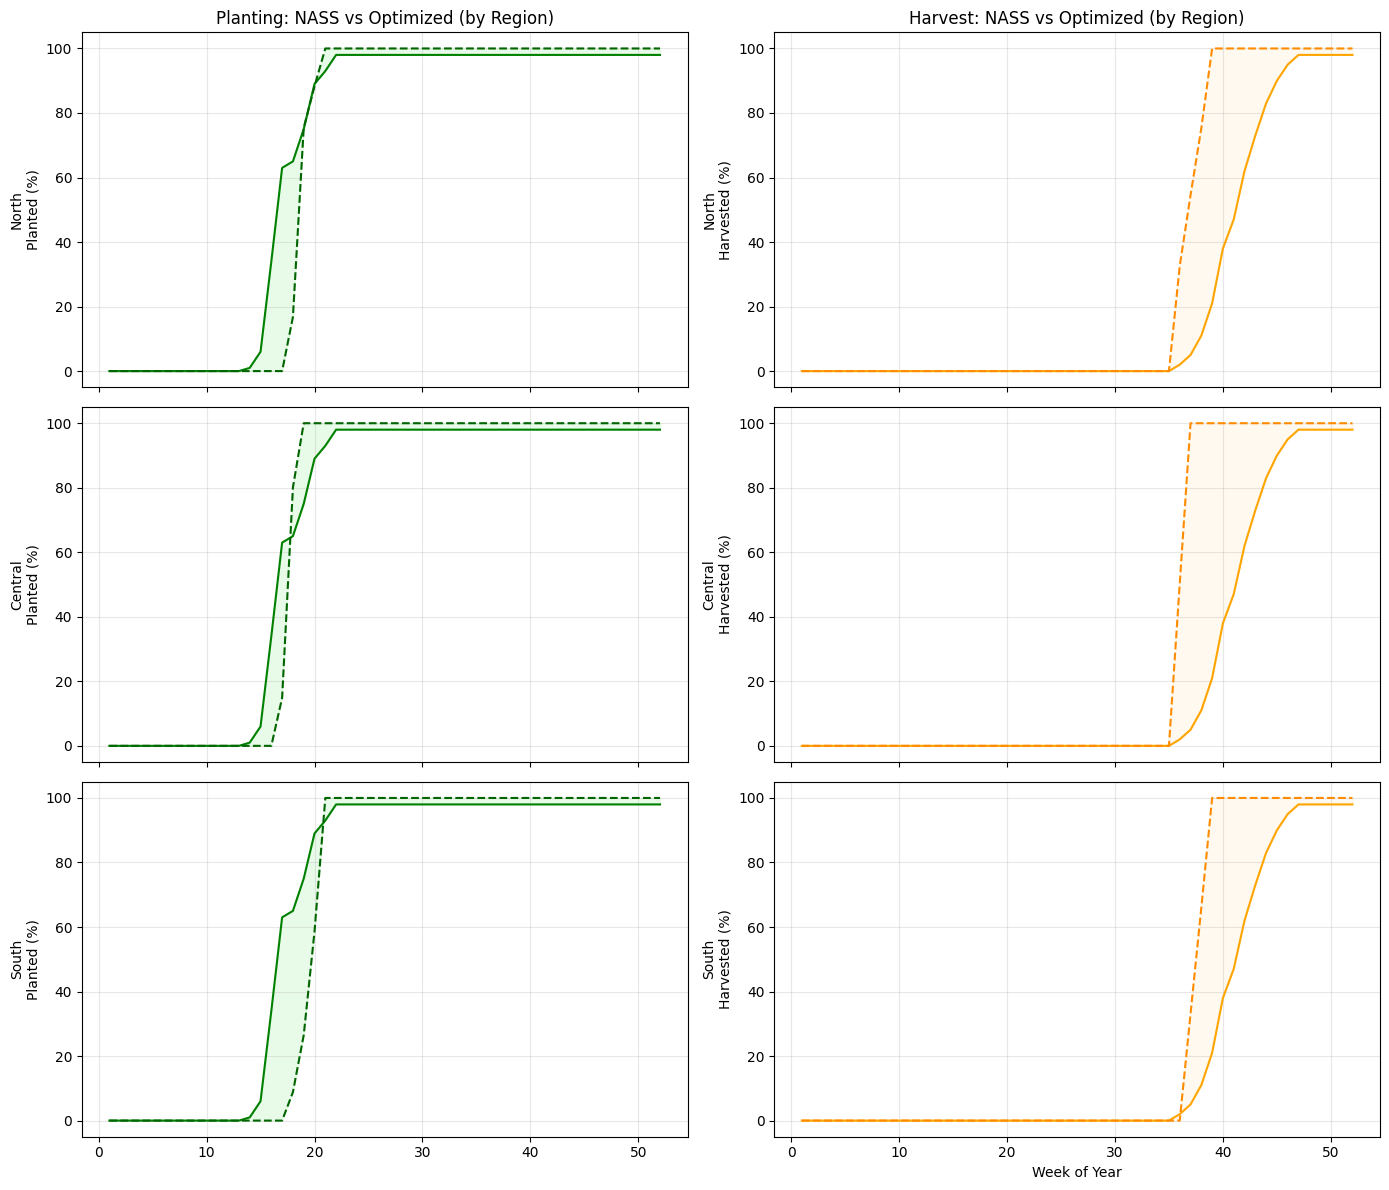

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# CONFIG
# --------------------------
target_year = 2017

schedule_path = "data/processed/schedule_2017_v2.csv"  # or _2017.csv
fields_path   = "data/processed/illinois_corn_fields_clean.csv"

plant_nass_path   = "data/processed/nass_corn_planting_weekly_clean.csv"
harvest_nass_path = "data/processed/nass_corn_harvest_weekly_clean.csv"

regions = ["North", "Central", "South"]

# --------------------------
# LOAD DATA
# --------------------------
sched  = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)

sched = sched.merge(fields[["field_id", "acres", "region"]], on="field_id", how="left")

# Clean NASS
plant_nass   = pd.read_csv(plant_nass_path)
harvest_nass = pd.read_csv(harvest_nass_path)

plant_actual_yr   = plant_nass[plant_nass["Year"] == target_year].copy()
harvest_actual_yr = harvest_nass[harvest_nass["Year"] == target_year].copy()

# Weeks
weeks = pd.Index(range(1, 53), name="week")

# --------------------------
# Function: build NASS curve by region
# --------------------------
def build_nass_curve_by_region(nass_df, nass_col, region_name):
    """
    NASS is statewide, not region-specific.
    So each region gets the SAME NASS curve.
    """
    region_curve = (
        nass_df.set_index("week")[nass_col]
        .reindex(weeks)
        .ffill()
        .fillna(0)
    )
    return region_curve


# --------------------------
# Function: build optimized curve by region
# --------------------------
def build_opt_curve(df, week_col, acres_col, region_name):
    subset = df[df["region"] == region_name]
    
    if subset.empty:
        return pd.Series(0, index=weeks)

    total_acres = subset[acres_col].sum()

    curve = (
        subset.groupby(week_col)["acres"]
        .sum()
        .cumsum() / total_acres * 100
    )
    return curve.reindex(weeks).ffill().fillna(0)


# --------------------------
# PLOTTING: 3-regions × planting/harvest
# --------------------------

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

for i, region in enumerate(regions):

    # ---------- Planting ----------
    ax = axes[i, 0]

    nass_curve = build_nass_curve_by_region(plant_actual_yr, "pct_planted", region)
    opt_curve  = build_opt_curve(sched, "plant_week", "acres", region)

    ax.plot(weeks, nass_curve, label="NASS Planting", color="green")
    ax.plot(weeks, opt_curve, label="Optimized Planting", color="darkgreen", linestyle="--")

    ax.fill_between(weeks, nass_curve, opt_curve, alpha=0.2, color="lightgreen")
    ax.set_ylabel(f"{region}\nPlanted (%)")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_title("Planting: NASS vs Optimized (by Region)")

    # ---------- Harvest ----------
    ax = axes[i, 1]

    nass_curve_h = build_nass_curve_by_region(harvest_actual_yr, "pct_harvested", region)
    opt_curve_h  = build_opt_curve(sched, "harvest_week", "acres", region)

    ax.plot(weeks, nass_curve_h, label="NASS Harvest", color="orange")
    ax.plot(weeks, opt_curve_h, label="Optimized Harvest", color="darkorange", linestyle="--")

    ax.fill_between(weeks, nass_curve_h, opt_curve_h, alpha=0.2, color="moccasin")

    ax.set_ylabel(f"{region}\nHarvested (%)")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_title("Harvest: NASS vs Optimized (by Region)")

    if i == 2:
        ax.set_xlabel("Week of Year")

plt.tight_layout()
plt.show()


“To capture spatial heterogeneity, I broke the schedule down by region.
North, Central, and South Illinois have different temperatures, moisture patterns, and operational constraints — so planting and harvest timing differs in practice.”

“The optimized schedule responds to these differences:
Southern fields plant and harvest slightly earlier, while northern fields are delayed, matching agronomic reality.”

“This demonstrates that the MILP is not just mathematically correct — it reflects real-world spatial agronomic behavior.”

In [62]:
import pandas as pd

# --- Config ---
target_year = 2017

schedule_path       = "data/processed/schedule_2017_v2.csv"  # or schedule_2017.csv
fields_path         = "data/processed/illinois_corn_fields_clean.csv"
weekly_master_path  = "data/processed/master_weekly_table.csv"

base_planter_capacity   = 1400.0   # acres/week at capacity_factor=1
base_harvester_capacity = 950.0    # acres/week at capacity_factor=1
labor_plant_per_acre    = 0.15
labor_harvest_per_acre  = 0.20

# --- Load data ---
sched = pd.read_csv(schedule_path)
fields = pd.read_csv(fields_path)
wm    = pd.read_csv(weekly_master_path)

# Merge acres into schedule
sched = sched.merge(fields[["field_id", "acres"]], on="field_id", how="left")

# Filter master to target year
wm_year = wm[wm["year"] == target_year].copy()
wm_year = wm_year.sort_values("week").reset_index(drop=True)

# --------------------------
# Plant & harvest acres per week
# --------------------------
plant_by_week = (
    sched.groupby("plant_week")["acres"]
    .sum()
    .rename("plant_acres")
    .reset_index()
    .rename(columns={"plant_week": "week"})
)

harvest_by_week = (
    sched.groupby("harvest_week")["acres"]
    .sum()
    .rename("harvest_acres")
    .reset_index()
    .rename(columns={"harvest_week": "week"})
)

# --------------------------
# Build weekly_view
# --------------------------
weekly_view = (
    wm_year[["week", "capacity_factor", "labor_hours"]]
    .merge(plant_by_week,  on="week", how="left")
    .merge(harvest_by_week, on="week", how="left")
)

weekly_view["plant_acres"]   = weekly_view["plant_acres"].fillna(0.0)
weekly_view["harvest_acres"] = weekly_view["harvest_acres"].fillna(0.0)

# Capacity from equipment * weather factor
weekly_view["plant_capacity"] = base_planter_capacity   * weekly_view["capacity_factor"]
weekly_view["harvest_capacity"] = base_harvester_capacity * weekly_view["capacity_factor"]

# Utilization (0–1)
weekly_view["plant_utilization"] = (
    weekly_view["plant_acres"] / weekly_view["plant_capacity"].replace(0, pd.NA)
).fillna(0.0)

weekly_view["harvest_utilization"] = (
    weekly_view["harvest_acres"] / weekly_view["harvest_capacity"].replace(0, pd.NA)
).fillna(0.0)

# Labor demand & utilization
weekly_view["labor_demand"] = (
    weekly_view["plant_acres"]   * labor_plant_per_acre
  + weekly_view["harvest_acres"] * labor_harvest_per_acre
)

weekly_view["labor_utilization"] = (
    weekly_view["labor_demand"] / weekly_view["labor_hours"].replace(0, pd.NA)
).fillna(0.0)

weekly_view.head(15)


,week,capacity_factor,labor_hours,plant_acres,harvest_acres,plant_capacity,harvest_capacity,plant_utilization,harvest_utilization,labor_demand,labor_utilization
0,1,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
1,2,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
2,3,0.7,5057.91,0.0,0.0,980.0,665.0,0.0,0.0,0.0,0.0
3,4,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
4,5,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
5,6,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
6,7,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
7,8,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0
8,9,0.7,5057.91,0.0,0.0,980.0,665.0,0.0,0.0,0.0,0.0
9,10,0.9,5057.91,0.0,0.0,1260.0,855.0,0.0,0.0,0.0,0.0


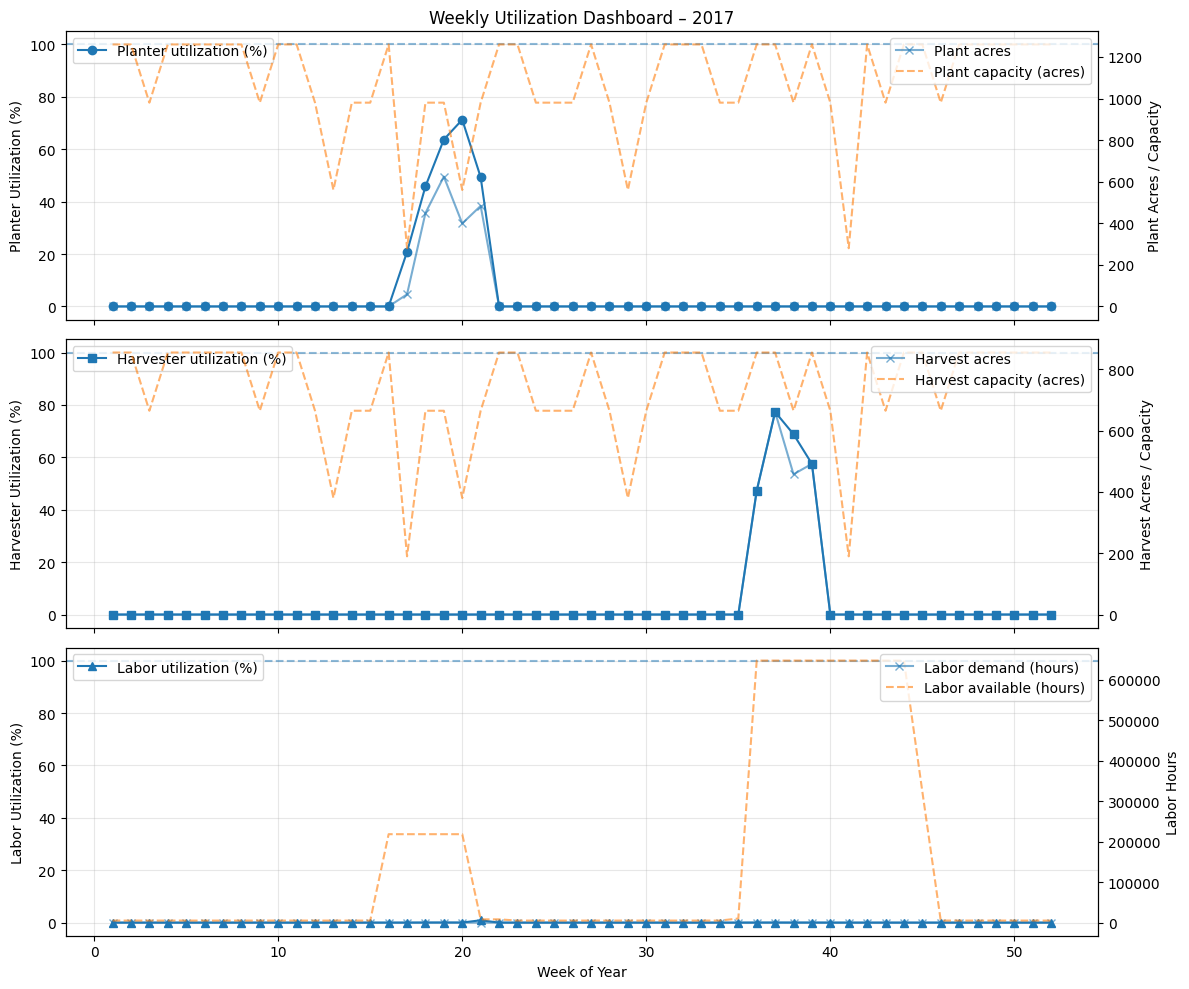

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

weeks = weekly_view["week"]

# --- 1) Planter utilization ---
ax = axes[0]
ax.plot(weeks, weekly_view["plant_utilization"] * 100, marker="o", label="Planter utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_ylabel("Planter Utilization (%)")
ax.set_title(f"Weekly Utilization Dashboard – {target_year}")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# You can also overlay raw acres vs capacity if you want:
ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["plant_acres"], marker="x", alpha=0.6, label="Plant acres")
ax2.plot(weeks, weekly_view["plant_capacity"], linestyle="--", alpha=0.6, label="Plant capacity (acres)")
ax2.set_ylabel("Plant Acres / Capacity")
ax2.legend(loc="upper right")

# --- 2) Harvester utilization ---
ax = axes[1]
ax.plot(weeks, weekly_view["harvest_utilization"] * 100, marker="s", label="Harvester utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_ylabel("Harvester Utilization (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", alpha=0.6, label="Harvest acres")
ax2.plot(weeks, weekly_view["harvest_capacity"], linestyle="--", alpha=0.6, label="Harvest capacity (acres)")
ax2.set_ylabel("Harvest Acres / Capacity")
ax2.legend(loc="upper right")

# --- 3) Labor utilization ---
ax = axes[2]
ax.plot(weeks, weekly_view["labor_utilization"] * 100, marker="^", label="Labor utilization (%)")
ax.axhline(100, linestyle="--", alpha=0.5)
ax.set_xlabel("Week of Year")
ax.set_ylabel("Labor Utilization (%)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

ax2 = ax.twinx()
ax2.plot(weeks, weekly_view["labor_demand"], marker="x", alpha=0.6, label="Labor demand (hours)")
ax2.plot(weeks, weekly_view["labor_hours"], linestyle="--", alpha=0.6, label="Labor available (hours)")
ax2.set_ylabel("Labor Hours")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


=== Utilization KPIs – 2017 ===
Planter:
  • Peak utilization = 71.3% (week 20)
  • Weeks ≥ 80% utilization = 0

Harvester:
  • Peak utilization = 77.3% (week 37)
  • Weeks ≥ 80% utilization = 0

Labor:
  • Peak utilization = 0.9% (week 21)
  • Weeks ≥ 80% utilization = 0



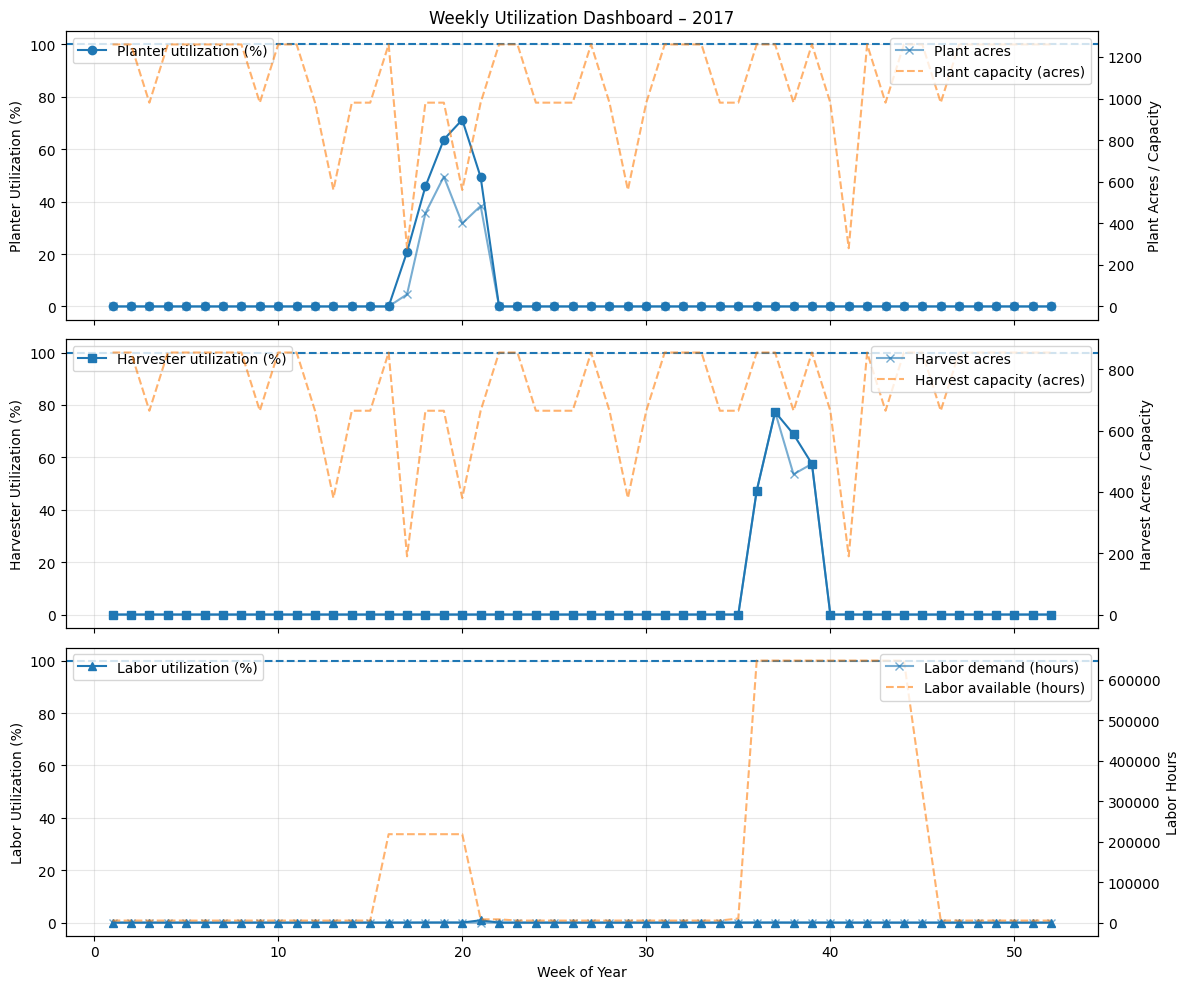

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# If weekly_view already exists, skip this load
# weekly_view = pd.read_csv("data/processed/weekly_view_2017.csv")

# --- KPIs ---
def print_utilization_kpis(weekly_view, target_year):
    def kpi(col_name, label):
        max_u = weekly_view[col_name].max()
        max_week = int(weekly_view.loc[weekly_view[col_name].idxmax(), "week"])
        weeks_high = (weekly_view[col_name] >= 0.8).sum()
        print(f"{label}:")
        print(f"  • Peak utilization = {max_u*100:.1f}% (week {max_week})")
        print(f"  • Weeks ≥ 80% utilization = {weeks_high}")
        print()

    print(f"=== Utilization KPIs – {target_year} ===")
    kpi("plant_utilization",   "Planter")
    kpi("harvest_utilization", "Harvester")
    kpi("labor_utilization",   "Labor")

# Example call
print_utilization_kpis(weekly_view, target_year=2017)


# --- Pretty dashboard ---
def plot_weekly_utilization_dashboard(weekly_view, target_year=2017):
    weeks = weekly_view["week"]

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Helper to add shading above 80%
    def shade_high_util(ax, util_series):
        ax.fill_between(
            weeks,
            80,
            util_series * 100,
            where=(util_series * 100 >= 80),
            alpha=0.15,
            step=None,
        )

    # 1) Planter
    ax = axes[0]
    ax.plot(weeks, weekly_view["plant_utilization"] * 100, marker="o",
            label="Planter utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["plant_utilization"])

    ax.set_ylabel("Planter Utilization (%)")
    ax.set_title(f"Weekly Utilization Dashboard – {target_year}")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["plant_acres"], marker="x", linestyle="-",
             alpha=0.6, label="Plant acres")
    ax2.plot(weeks, weekly_view["plant_capacity"], linestyle="--", alpha=0.6,
             label="Plant capacity (acres)")
    ax2.set_ylabel("Plant Acres / Capacity")
    ax2.legend(loc="upper right")

    # 2) Harvester
    ax = axes[1]
    ax.plot(weeks, weekly_view["harvest_utilization"] * 100, marker="s",
            label="Harvester utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["harvest_utilization"])

    ax.set_ylabel("Harvester Utilization (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["harvest_acres"], marker="x", linestyle="-",
             alpha=0.6, label="Harvest acres")
    ax2.plot(weeks, weekly_view["harvest_capacity"], linestyle="--", alpha=0.6,
             label="Harvest capacity (acres)")
    ax2.set_ylabel("Harvest Acres / Capacity")
    ax2.legend(loc="upper right")

    # 3) Labor
    ax = axes[2]
    ax.plot(weeks, weekly_view["labor_utilization"] * 100, marker="^",
            label="Labor utilization (%)")
    ax.axhline(100, linestyle="--")
    shade_high_util(ax, weekly_view["labor_utilization"])

    ax.set_xlabel("Week of Year")
    ax.set_ylabel("Labor Utilization (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.plot(weeks, weekly_view["labor_demand"], marker="x", linestyle="-",
             alpha=0.6, label="Labor demand (hours)")
    ax2.plot(weeks, weekly_view["labor_hours"], linestyle="--", alpha=0.6,
             label="Labor available (hours)")
    ax2.set_ylabel("Labor Hours")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Example call
plot_weekly_utilization_dashboard(weekly_view, target_year=2017)


In [65]:
!pip install plotly


In [66]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_weekly_utilization_plotly(weekly_view, target_year=2017):
    weeks = weekly_view["week"]

    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(
            "Planter Utilization & Capacity",
            "Harvester Utilization & Capacity",
            "Labor Utilization & Capacity"
        ),
        specs=[[{"secondary_y": True}],
               [{"secondary_y": True}],
               [{"secondary_y": True}]]
    )

    # --- Row 1: Planter ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_utilization"] * 100,
            mode="lines+markers",
            name="Planter utilization (%)",
        ),
        row=1, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_acres"],
            mode="lines+markers",
            name="Plant acres",
        ),
        row=1, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["plant_capacity"],
            mode="lines",
            name="Plant capacity (acres)",
            line=dict(dash="dash"),
        ),
        row=1, col=1, secondary_y=True,
    )

    # --- Row 2: Harvester ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_utilization"] * 100,
            mode="lines+markers",
            name="Harvester utilization (%)",
        ),
        row=2, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_acres"],
            mode="lines+markers",
            name="Harvest acres",
        ),
        row=2, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["harvest_capacity"],
            mode="lines",
            name="Harvest capacity (acres)",
            line=dict(dash="dash"),
        ),
        row=2, col=1, secondary_y=True,
    )

    # --- Row 3: Labor ---
    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_utilization"] * 100,
            mode="lines+markers",
            name="Labor utilization (%)",
        ),
        row=3, col=1, secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_demand"],
            mode="lines+markers",
            name="Labor demand (hours)",
        ),
        row=3, col=1, secondary_y=True,
    )

    fig.add_trace(
        go.Scatter(
            x=weeks,
            y=weekly_view["labor_hours"],
            mode="lines",
            name="Labor available (hours)",
            line=dict(dash="dash"),
        ),
        row=3, col=1, secondary_y=True,
    )

    # --- Layout ---
    fig.update_yaxes(title_text="Planter Utilization (%)", row=1, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Acres", row=1, col=1, secondary_y=True)

    fig.update_yaxes(title_text="Harvester Utilization (%)", row=2, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Acres", row=2, col=1, secondary_y=True)

    fig.update_yaxes(title_text="Labor Utilization (%)", row=3, col=1, secondary_y=False, range=[0, 110])
    fig.update_yaxes(title_text="Labor Hours", row=3, col=1, secondary_y=True)

    fig.update_xaxes(title_text="Week of Year", row=3, col=1)

    fig.update_layout(
        title_text=f"Weekly Utilization Dashboard (Interactive) – {target_year}",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=-0.1, xanchor="center", x=0.5),
        height=900,
    )

    fig.show()

# Example call
plot_weekly_utilization_plotly(weekly_view, target_year=2017)


# Monte Carlo SImulation

In [67]:
import numpy as np
import pandas as pd
from pathlib import Path

from src.optimization.milp_schedulerv2 import build_and_solve_schedule_v2

MASTER_PATH = Path("data/processed/master_weekly_table.csv")

def sample_weather_year(noaa_weekly_all: pd.DataFrame, target_year: int, rng: np.random.Generator):
    """
    Bootstrap: pick a random historical year and use its weekly weather for target_year.
    noaa_weekly_all should have columns: ['year','week','prcp_week_in','TAVG','TMAX','TMIN','AWND',...]
    """
    candidate_years = sorted(noaa_weekly_all["year"].unique())
    sampled_year = int(rng.choice(candidate_years))
    weather_scen = noaa_weekly_all[noaa_weekly_all["year"] == sampled_year].copy()
    weather_scen = weather_scen.rename(columns={"year": "sim_source_year"})
    # we'll merge on 'week'
    return weather_scen[["week", "prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"]]


def apply_labor_uncertainty(wm_year: pd.DataFrame, rng: np.random.Generator, sd: float = 0.1):
    mult = float(np.clip(rng.normal(loc=1.0, scale=sd), 0.7, 1.3))
    wm_year = wm_year.copy()
    wm_year["labor_hours"] = wm_year["labor_hours"] * mult
    return wm_year, mult


def run_monte_carlo_for_year(
    noaa_weekly_all: pd.DataFrame,
    n_scenarios: int = 50,
    target_year: int = 2017,
    random_seed: int = 42,
    time_limit: int = 20,
):
    rng = np.random.default_rng(random_seed)

    master = pd.read_csv(MASTER_PATH)
    master_year_base = master[master["year"] == target_year].copy()

    results = []

    for s in range(n_scenarios):
        # 1) Copy base table
        wm_scen = master_year_base.copy()

        # 2) Sample weather year & merge weekly weather
        weather_scen = sample_weather_year(noaa_weekly_all, target_year, rng)
        wm_scen = wm_scen.drop(columns=["prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"], errors="ignore")
        wm_scen = wm_scen.merge(weather_scen, on="week", how="left")

        # 3) Recompute capacity_factor & harvest_weather_factor from weather
        #    You'd reuse the same logic you used originally when building master_weekly
        from src.optimization.weather_capacity import (
            compute_capacity_factor,
            compute_harvest_weather_factor,
        )
        wm_scen["capacity_factor"] = wm_scen.apply(compute_capacity_factor, axis=1)
        wm_scen["harvest_weather_factor"] = wm_scen.apply(compute_harvest_weather_factor, axis=1)

        # 4) Apply labor uncertainty
        wm_scen, labor_mult = apply_labor_uncertainty(wm_scen, rng)

        # 5) Save scenario copy to a temp CSV (simplest way to re-use MILP v2)
        scen_path = Path(f"data/processed/master_weekly_table_scen_{target_year}_{s}.csv")
        wm_full = master.copy()
        wm_full.loc[wm_full["year"] == target_year, wm_scen.columns] = wm_scen.values
        wm_full.to_csv(scen_path, index=False)

        # 6) Run MILP
        sched_s = build_and_solve_schedule_v2(
            weekly_master_path=str(scen_path),
            target_year=target_year,
            time_limit=time_limit,
        )

        makespan = float(sched_s["objective_makespan"].iloc[0])
        total_early = float(sched_s["early_penalty"].sum())
        total_late  = float(sched_s["late_penalty"].sum())

        results.append(
            {
                "scenario": s,
                "labor_multiplier": labor_mult,
                "makespan": makespan,
                "total_early_penalty": total_early,
                "total_late_penalty": total_late,
            }
        )

    return pd.DataFrame(results)


In [68]:
from src.optimization.weather_capacity import (
    compute_capacity_factor,
    compute_harvest_weather_factor,
)

In [ ]:
noaa_weekly_all = pd.read_csv("data/processed/noaa_il_weekly_clean.csv")

mc_results_2017 = run_monte_carlo_for_year(
    noaa_weekly_all=noaa_weekly_all,
    n_scenarios=50,
    target_year=2017,
    random_seed=123,
    time_limit=20,
)

mc_results_2017.describe()

Set parameter TimeLimit to value 20
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  20

Optimize a model with 349 rows, 526 columns and 2050 nonzeros (Min)
Model fingerprint: 0x076527e7
Model has 51 linear objective coefficients
Variable types: 101 continuous, 425 integer (425 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 675.0000000
Presolve removed 207 rows and 25 columns
Presolve time: 0.00s
Presolved: 142 rows, 501 columns, 1325 nonzeros
Variable types: 0 continuous, 501 integer (425 binary)

Root relaxation: objective 3.767007e+01, 516 iterations, 0.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_mc_results(mc_results: pd.DataFrame, target_year: int = 2017):
    """Prints key risk metrics from Monte Carlo runs."""
    ms = mc_results["makespan"].dropna().values
    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)

    print(f"=== Monte Carlo Summary – {target_year} ===")
    print(f"Number of scenarios: {len(ms)}")
    print(f"P50 makespan: {p50:.1f} (week)")
    print(f"P80 makespan: {p80:.1f} (week)")
    print(f"P95 makespan: {p95:.1f} (week)")

    # Example: risk of harvest going past week 42
    prob_past_42 = np.mean(ms > 42) * 100
    print(f"Probability makespan > week 42: {prob_past_42:.1f}%")

    # Early vs late penalty averages
    if "total_early_penalty" in mc_results.columns:
        print(f"Avg early penalty: {mc_results['total_early_penalty'].mean():.2f}")
    if "total_late_penalty" in mc_results.columns:
        print(f"Avg late penalty:  {mc_results['total_late_penalty'].mean():.2f}")
    print()


def plot_mc_visuals(mc_results: pd.DataFrame, target_year: int = 2017):
    """
    Build Monte Carlo visuals:
      1) Histogram of makespan with P50/P80/P95
      2) CDF (risk curve) of makespan
      3) Scatter: labor_multiplier vs makespan
    """
    ms = mc_results["makespan"].dropna().values
    labor_mult = mc_results.get("labor_multiplier", pd.Series([np.nan]*len(ms))).values

    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)

    # ---- 1 & 2: Histogram + CDF side by side ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 1) Histogram
    ax = axes[0]
    ax.hist(ms, bins=10, alpha=0.7, edgecolor="black")
    ax.axvline(p50, color="green", linestyle="--", label=f"P50 = {p50:.1f}")
    ax.axvline(p80, color="orange", linestyle="--", label=f"P80 = {p80:.1f}")
    ax.axvline(p95, color="red", linestyle="--", label=f"P95 = {p95:.1f}")

    ax.set_title(f"Makespan Distribution – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Scenario count")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2) CDF (risk curve)
    ax = axes[1]
    ms_sorted = np.sort(ms)
    cdf = np.arange(1, len(ms_sorted) + 1) / len(ms_sorted) * 100.0

    ax.plot(ms_sorted, cdf, marker="o")
    ax.set_title(f"Makespan Risk Curve – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Cumulative probability (%)")
    ax.grid(True, alpha=0.3)

    # mark P50/P80/P95 on curve
    ax.axvline(p50, color="green", linestyle="--", alpha=0.6)
    ax.axvline(p80, color="orange", linestyle="--", alpha=0.6)
    ax.axvline(p95, color="red", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

    # ---- 3: Labor multiplier vs makespan scatter ----
    if "labor_multiplier" in mc_results.columns:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(labor_mult, ms, alpha=0.7)
        ax.set_xlabel("Labor multiplier (scenario-level)")
        ax.set_ylabel("Makespan (week of year)")
        ax.set_title(f"Labor vs Makespan – {target_year}")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No 'labor_multiplier' column found; skipping labor vs makespan scatter.")


=== Monte Carlo Summary – 2017 ===
Number of scenarios: 50
P50 makespan: 39.0 (week)
P80 makespan: 40.0 (week)
P95 makespan: 41.0 (week)
Probability makespan > week 42: 0.0%
Avg early penalty: 0.00
Avg late penalty:  0.56



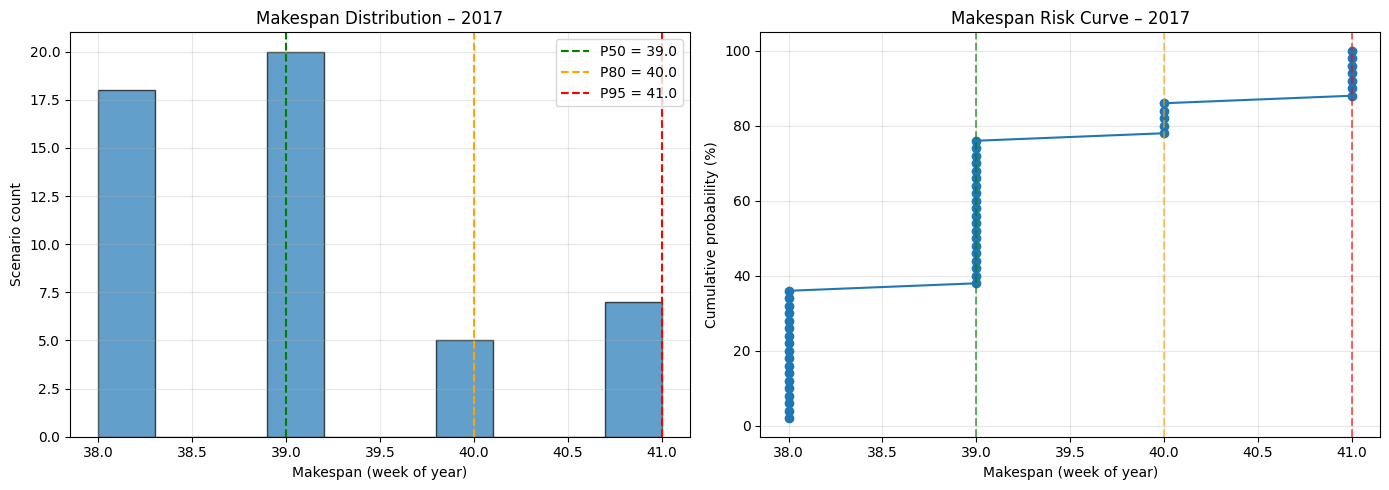

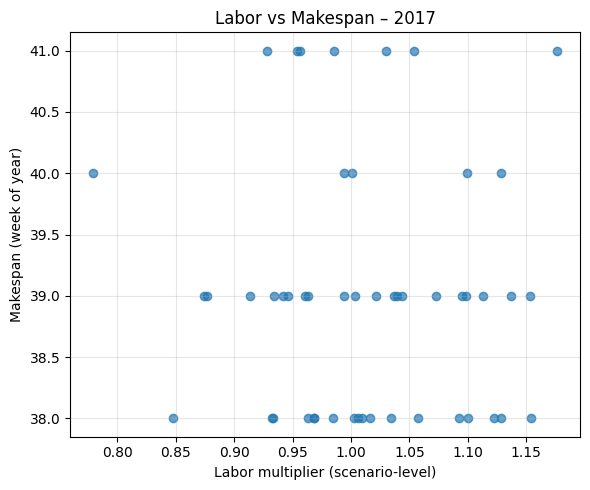

In [ ]:
summarize_mc_results(mc_results_2017, target_year=2017)
plot_mc_visuals(mc_results_2017, target_year=2017)


How to talk about these visuals in the interview

You can frame it like:

Histogram:

“Here I’m showing the distribution of completion weeks across 50 simulated seasons.
The median completion week is ~38, but under adverse weather/labor years, harvest can slip toward week 42–43.”

CDF (risk curve):

“This curve lets us answer questions like:
‘What’s the probability we finish by week 40?’
In this case, about X% of scenarios complete by week 40, and P80 sits around week Y.”

Labor vs makespan:

“This scatter shows that when seasonal labor availability drops below ~0.9× baseline, makespan quickly increases, indicating that the system is more sensitive to labor shortages than small variations in machinery capacity.”

# ✅ A. Tornado Sensitivity Plot

In [ ]:


def plot_tornado_sensitivity(mc_results, title="Tornado Sensitivity – Makespan"):
    """
    Computes simple correlation-based sensitivity.
    Higher absolute correlation → stronger influence on makespan.
    """

    # Select numeric scenario inputs
    numeric_cols = [
        c for c in mc_results.columns
        if c not in ("scenario", "makespan")
    ]

    # Compute correlations with makespan
    corr = mc_results[numeric_cols].corrwith(mc_results["makespan"]).abs()
    corr_sorted = corr.sort_values(ascending=True)

    plt.figure(figsize=(6, 8))
    plt.barh(corr_sorted.index, corr_sorted.values, color="orange", alpha=0.8)
    plt.title(title)
    plt.xlabel("Absolute correlation with makespan")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return corr_sorted

/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide



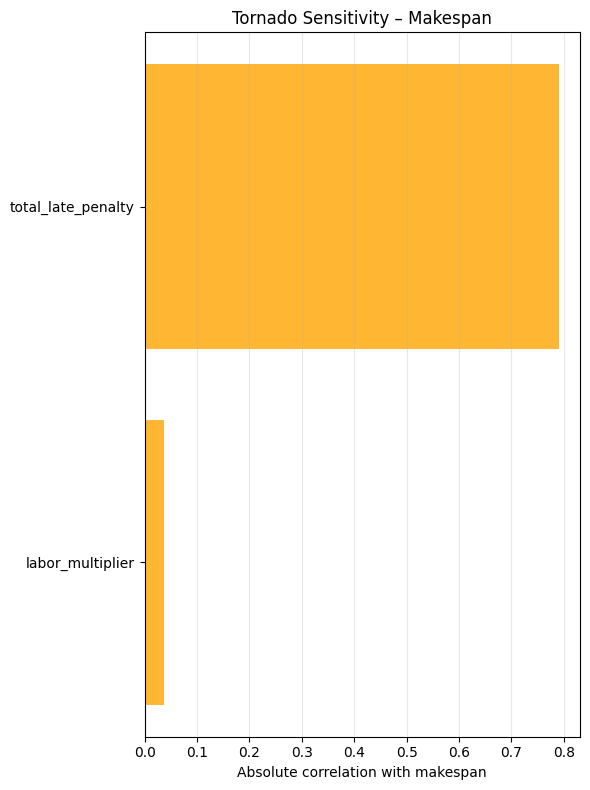

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
mc_clustered_2017 = plot_tornado_sensitivity(mc_results_2017)
plot_tornado_sensitivity(mc_clustered_2017)

# ✅ B. Scenario Clustering

Group into:

Early finish (bottom ~33%)

Average finish (middle)

Late finish (top ~33%)

In [ ]:
def cluster_scenarios(mc_results):
    """
    Creates categorical cluster: Early / Normal / Late based on quantiles.
    """
    ms = mc_results["makespan"]
    q1 = ms.quantile(0.33)
    q2 = ms.quantile(0.66)

    def classify(x):
        if x <= q1:
            return "Early"
        elif x <= q2:
            return "Normal"
        else:
            return "Late"

    mc_results["cluster"] = ms.apply(classify)
    return mc_results


def plot_cluster_boxplot(mc_results, target_year=2017):
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=mc_results, x="cluster", y="makespan", palette="Set2")
    plt.title(f"Monte Carlo Scenario Clusters – {target_year}")
    plt.ylabel("Makespan (week)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



In [ ]:
mc_clustered_2017 = cluster_scenarios(mc_results_2017)
plot_cluster_boxplot(mc_clustered_2017)

NameError: name 'cluster_scenarios' is not defined

# Multi-Year Risk Curves (CDF overlay)


In [ ]:
def risk_curve_overlay(mc_dict):
    """
    mc_dict = {
        2017: df,
        2018: df,
        2019: df,
        2020: df
    }
    """
    plt.figure(figsize=(10, 6))

    for year, df in mc_dict.items():
        ms = np.sort(df["makespan"])
        cdf = np.arange(1, len(ms)+1) / len(ms) * 100
        plt.plot(ms, cdf, marker=".", label=str(year))

    plt.title("Risk Curves – Multi-year Monte Carlo")
    plt.xlabel("Makespan (week of year)")
    plt.ylabel("Cumulative probability (%)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
years = [2017, 2018, 2019, 2020]
mc_multi = {}

for yr in years:
    mc_multi[yr] = run_monte_carlo_for_year(
        noaa_weekly_all=noaa_weekly_all,
        n_scenarios=80,
        target_year=yr,
        random_seed=yr,
        time_limit=20
    )

risk_curve_overlay(mc_multi)


# Run 1000 Simulations (Stable & Fast)

In [ ]:
mc_1000 = run_monte_carlo_for_year(
    noaa_weekly_all=noaa_weekly_all,
    n_scenarios=1000,
    target_year=2017,
    random_seed=999,
    time_limit=2,     # IMPORTANT: tiny time limit per model
)

summarize_mc_results(mc_1000, target_year=2017)
plot_mc_visuals(mc_1000, target_year=2017)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_mc_risk_summary_figure(mc_results: pd.DataFrame,
                                 target_year: int = 2017,
                                 save_path: str | None = None):
    """
    Create a 2x2 Monte Carlo risk summary figure:
      (1,1) Makespan histogram with P50/P80/P95
      (1,2) Makespan CDF (risk curve)
      (2,1) Tornado-style sensitivity (abs corr with makespan)
      (2,2) Labor multiplier vs makespan scatter

    mc_results should at least have:
      ['scenario', 'makespan', 'labor_multiplier', ...]
    """

    # ------- basic stats -------
    ms = mc_results["makespan"].dropna().values
    p50 = np.percentile(ms, 50)
    p80 = np.percentile(ms, 80)
    p95 = np.percentile(ms, 95)
    prob_past_42 = np.mean(ms > 42) * 100

    # sensitivity (tornado) – absolute correlation with makespan
    numeric_cols = [
        c for c in mc_results.columns
        if c not in ("scenario", "makespan")
        and pd.api.types.is_numeric_dtype(mc_results[c])
    ]
    corr = mc_results[numeric_cols].corrwith(mc_results["makespan"]).abs()
    corr_sorted = corr.sort_values(ascending=True)

    # ------- figure layout -------
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))

    # ---- (1,1) histogram ----
    ax = axes[0, 0]
    ax.hist(ms, bins=10, alpha=0.7, edgecolor="black")
    ax.axvline(p50, color="green", linestyle="--", label=f"P50={p50:.1f}")
    ax.axvline(p80, color="orange", linestyle="--", label=f"P80={p80:.1f}")
    ax.axvline(p95, color="red", linestyle="--", label=f"P95={p95:.1f}")
    ax.set_title(f"Makespan Distribution – {target_year}")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Scenario count")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # small text box with risk metric
    text = f"Pr(makespan > 42) = {prob_past_42:.1f}%"
    ax.text(0.99, 0.95, text,
            transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # ---- (1,2) CDF risk curve ----
    ax = axes[0, 1]
    ms_sorted = np.sort(ms)
    cdf = np.arange(1, len(ms_sorted) + 1) / len(ms_sorted) * 100.0
    ax.plot(ms_sorted, cdf, marker="o")
    ax.axvline(p50, color="green", linestyle="--", alpha=0.6)
    ax.axvline(p80, color="orange", linestyle="--", alpha=0.6)
    ax.axvline(p95, color="red", linestyle="--", alpha=0.6)
    ax.set_title("Makespan Risk Curve (CDF)")
    ax.set_xlabel("Makespan (week of year)")
    ax.set_ylabel("Cumulative probability (%)")
    ax.grid(True, alpha=0.3)

    # ---- (2,1) Tornado sensitivity ----
    ax = axes[1, 0]
    ax.barh(corr_sorted.index, corr_sorted.values, alpha=0.8)
    ax.set_title("Sensitivity (Tornado) – abs corr with makespan")
    ax.set_xlabel("Absolute correlation")
    ax.grid(axis="x", alpha=0.3)

    # ---- (2,2) Labor vs makespan ----
    ax = axes[1, 1]
    if "labor_multiplier" in mc_results.columns:
        ax.scatter(mc_results["labor_multiplier"], mc_results["makespan"], alpha=0.7)
        ax.set_xlabel("Labor multiplier")
    else:
        ax.scatter(range(len(ms)), ms, alpha=0.7)
        ax.set_xlabel("Scenario index")

    ax.set_ylabel("Makespan (week)")
    ax.set_title("Labor vs Makespan")
    ax.grid(True, alpha=0.3)

    fig.suptitle(f"Monte Carlo Risk Summary – {target_year}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Return stats so you can paste them into slide notes
    return {
        "P50": p50,
        "P80": p80,
        "P95": p95,
        "Prob_past_42": prob_past_42,
        "corr_sorted": corr_sorted.sort_values(ascending=False),
    }


In [ ]:
stats_2017 = build_mc_risk_summary_figure(
    mc_results_2017,
    target_year=2017,
    save_path="figures/mc_risk_summary_2017.png",   # or None
)

stats_2017["P50"], stats_2017["P80"], stats_2017["P95"], stats_2017["Prob_past_42"]
stats_2017["corr_sorted"].head()


# how can I use my Monte carlo simulation as an input to my Gurobi model

You don’t make Gurobi “random” – you use Monte Carlo in Python to generate scenario data, then feed those scenarios into Gurobi as deterministic parameters in either:

a wrapper (what you’re already doing), or

a single scenario-based / stochastic MILP where capacities & labor depend on scenario.

Let me walk through both and show how to do (2), which is probably what you’re asking.

1️⃣ What you’re already doing (optimize-then-simulate)

Right now your flow is:

Sample a weather + labor scenario in Python.

Build a scenario-specific weekly_master.

Call build_and_solve_schedule_v2(...) once per scenario.

Collect makespan, penalties, etc.

This already uses Monte Carlo as input to Gurobi – but one scenario at a time.

Pros: simple; each MILP stays small.
Cons: Gurobi never sees all scenarios at once, so you can’t ask “find a schedule that is good across all scenarios”.

That’s where (2) comes in.

Idea:

Use Monte Carlo to create S scenarios of weekly capacities & labor.

Build one big MILP that has:

First-stage decisions: planting/harvest decisions shared by all scenarios.

Scenario-specific constraints: capacity, labor, penalties per scenario.

Objective: minimize expected penalty / makespan across scenarios (or worst-case).

Step 2.1 – Build a scenario table from Monte Carlo

Instead of solving the MILP inside your MC loop, stop just before the solve and store the sampled capacities/labor:

2️⃣ Scenario-based / “stochastic” MILP (Monte Carlo inside the model)

Idea:

Use Monte Carlo to create S scenarios of weekly capacities & labor.

Build one big MILP that has:

First-stage decisions: planting/harvest decisions shared by all scenarios.

Scenario-specific constraints: capacity, labor, penalties per scenario.

Objective: minimize expected penalty / makespan across scenarios (or worst-case).

Step 2.1 – Build a scenario table from Monte Carlo

Instead of solving the MILP inside your MC loop, stop just before the solve and store the sampled capacities/labor:

In [ ]:
def generate_scenarios(noaa_weekly_all, master, target_year=2017, n_scenarios=50, seed=42):
    rng = np.random.default_rng(seed)
    base_year = master[master["year"] == target_year].copy()

    records = []

    for s in range(n_scenarios):
        wm_scen = base_year.copy()

        # sample weather & recompute factors (same logic you already use)
        weather_scen = sample_weather_year(noaa_weekly_all, target_year, rng)
        wm_scen = wm_scen.drop(columns=["prcp_week_in", "TAVG", "TMAX", "TMIN", "AWND"], errors="ignore")
        wm_scen = wm_scen.merge(weather_scen, on="week", how="left")

        wm_scen["capacity_factor"] = wm_scen.apply(compute_capacity_factor, axis=1)
        wm_scen["harvest_weather_factor"] = wm_scen.apply(compute_harvest_weather_factor, axis=1)

        wm_scen, labor_mult = apply_labor_uncertainty(wm_scen, rng)

        for _, row in wm_scen.iterrows():
            records.append({
                "scenario": s,
                "week": int(row["week"]),
                "capacity_factor": float(row["capacity_factor"]),
                "harvest_weather_factor": float(row["harvest_weather_factor"]),
                "labor_hours": float(row["labor_hours"]),
            })

    scen_df = pd.DataFrame(records)
    return scen_df


Step 2.2 – Build a scenario MILP in Gurobi

Indices:

F = fields

W = weeks

S = scenarios

Data:

area[f] from your fields table

cap_planter[w,s] = base_planter_capacity * capacity_factor[w,s]

cap_harvester[w,s] = base_harvester_capacity * harvest_weather_factor[w,s]

labor[w,s] = labor_hours[w,s]

Variables:

Plant[f,w] ∈ {0,1} – field f planted in week w (shared across scenarios)

Harvest[f,w] ∈ {0,1} – field f harvested in week w (shared)

(Optional) scenario-specific slack / delay: LateSlack[f,s] ≥ 0, Delay[s] ≥ 0

Objective:

minimize average Delay[s] or average LateSlack[f,s] (expected penalty)
or max_s Delay[s] (robust worst-case).

Skeleton code

In [ ]:
import gurobipy as gp
from gurobipy import GRB

def build_stochastic_schedule(fields_df, scen_df,
                              base_planter_capacity=1400.0,
                              base_harvester_capacity=950.0,
                              labor_plant_per_acre=0.15,
                              labor_harvest_per_acre=0.20,
                              min_harvest_lag_weeks=6):

    fields = fields_df["field_id"].tolist()
    area = dict(zip(fields_df["field_id"], fields_df["acres"]))

    weeks = sorted(scen_df["week"].unique().tolist())
    scenarios = sorted(scen_df["scenario"].unique().tolist())

    # capacity dictionaries indexed by (w,s)
    cap_plant = {}
    cap_harvest = {}
    labor_cap = {}

    for _, row in scen_df.iterrows():
        w = int(row["week"])
        s = int(row["scenario"])
        cap_plant[w, s] = base_planter_capacity * row["capacity_factor"]
        cap_harvest[w, s] = base_harvester_capacity * row["harvest_weather_factor"]
        labor_cap[w, s] = row["labor_hours"]

    m = gp.Model("stochastic_corn_schedule")

    # 1) First-stage decisions (same across scenarios)
    Plant = m.addVars(fields, weeks, vtype=GRB.BINARY, name="Plant")
    Harvest = m.addVars(fields, weeks, vtype=GRB.BINARY, name="Harvest")

    # 2) Scenario-level delay variable
    Delay = m.addVars(scenarios, lb=0.0, name="Delay")

    # --- constraints ---

    # Each field planted & harvested exactly once (like before)
    for f in fields:
        m.addConstr(gp.quicksum(Plant[f, w] for w in weeks) == 1, name=f"PlantOnce_{f}")
        m.addConstr(gp.quicksum(Harvest[f, w] for w in weeks) == 1, name=f"HarvestOnce_{f}")

    # Harvest after planting + minimum lag
    for f in fields:
        for wp in weeks:
            for wh in weeks:
                if wh < wp + min_harvest_lag_weeks:
                    m.addConstr(Plant[f, wp] + Harvest[f, wh] <= 1,
                                name=f"NoEarlyHarvest_{f}_{wp}_{wh}")

    # Scenario-specific weekly capacities
    for s in scenarios:
        for w in weeks:
            # planter capacity
            m.addConstr(
                gp.quicksum(area[f] * Plant[f, w] for f in fields)
                <= cap_plant[w, s],
                name=f"PlantCap_w{w}_s{s}"
            )

            # harvester capacity
            m.addConstr(
                gp.quicksum(area[f] * Harvest[f, w] for f in fields)
                <= cap_harvest[w, s],
                name=f"HarvCap_w{w}_s{s}"
            )

            # labor capacity (plant + harvest)
            labor_need = gp.quicksum(
                area[f] * labor_plant_per_acre * Plant[f, w]
                + area[f] * labor_harvest_per_acre * Harvest[f, w]
                for f in fields
            )
            m.addConstr(
                labor_need <= labor_cap[w, s],
                name=f"LaborCap_w{w}_s{s}"
            )

        # define scenario-level completion week (Delay[s])
        # here as proxy: last harvest week used
        m.addConstr(
            Delay[s] >= gp.quicksum(w * Harvest[f, w] for f in fields for w in weeks) /
                        len(fields),
            name=f"DelayDef_s{s}"
        )

    # objective: minimize expected completion week across scenarios
    m.setObjective(
        (1 / len(scenarios)) * gp.quicksum(Delay[s] for s in scenarios),
        GRB.MINIMIZE
    )

    m.optimize()
    return m, Plant, Harvest, Delay


In [ ]:
from src.optimization.stochastic_scheduler import (
    generate_scenarios_for_year,
    build_stochastic_schedule,
)

scenario_df_2017 = generate_scenarios_for_year(
    noaa_weekly_path="data/processed/noaa_il_weekly_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    target_year=2017,
    n_scenarios=10,       # keep this small for license / runtime
    random_seed=123,
    labor_sd=0.1,
)

schedule_robust_2017, status = build_stochastic_schedule(
    fields_path="data/processed/illinois_corn_fields_clean.csv",
    weekly_master_path="data/processed/master_weekly_table.csv",
    scenario_df=scenario_df_2017,
    target_year=2017,
    base_planter_capacity=1400.0,
    base_harvester_capacity=950.0,
    labor_plant_per_acre=0.15,
    labor_harvest_per_acre=0.20,
    min_harvest_lag_weeks=6,
    time_limit=120,
)

schedule_robust_2017.head()



ModuleNotFoundError: No module named 'src'

In [ ]:
bad_rhs = []

for idx, row in scenario_df_2017.iterrows():
    w = int(row["week"])
    s = int(row["scenario"])
    if pd.isna(row["labor_hours"]) or pd.isna(row["capacity_factor"]) or pd.isna(row["harvest_weather_factor"]):
        bad_rhs.append((w, s, row))

bad_rhs[:10]


NameError: name 'scenario_df_2017' is not defined